# Proyek Deep Learning 2023

Anggota Kelompok:

In [52]:
anggota = [
    ['Eben Haezer', '00000055583'],
    ['Gempar Bambang Godata', '00000067643'],
    ['Richard Faustine Wong', '00000056133'],
    ['Westley Wijaya', '00000056414']
]
    
for a in anggota:
    print("- {0} ({1})".format(a[0], a[1]))

- Eben Haezer (00000055583)
- Gempar Bambang Godata (00000067643)
- Richard Faustine Wong (00000056133)
- Westley Wijaya (00000056414)


### Import library

In [2]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd

import seaborn as sns

from tensorflow.keras.utils import load_img

from keras.preprocessing.image import ImageDataGenerator

from tensorflow import keras
from tensorflow.keras import layers

# InceptionV3
from tensorflow.keras.applications import InceptionV3

# MobileNetV2
from tensorflow.keras.applications import MobileNetV2

# Tuner
import keras_tuner

# Evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

### Import data

Data telah di-scrape secara manual dari Pixiv, di mana diperoleh 1000 gambar AI dan 1000 gambar non-AI.

Setelah itu, dilakukan konversi dari .jpg ke .png.

Tak hanya itu, data di-resize 256x256 dengan menggunakan ImageMagick

In [3]:
project_dir = 'E:\\DeepLearning\\PROJECT\\'

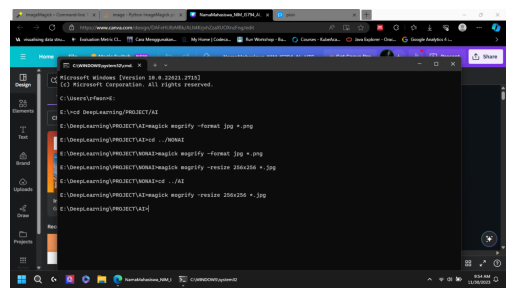

In [4]:
plt.axis('off')
plt.imshow(load_img(project_dir + "imagemagick-resize-256.png"))

Selanjutnya, kita coba mengakses direktori untuk gambar di training set untuk AI dan non-AI

In [5]:
ai_dir = project_dir + "pixiv\\trainval\\AI\\"

ai_paths = sorted(
    [os.path.join(ai_dir, fname)
    for fname in os.listdir(ai_dir)]
)

In [6]:
non_dir = project_dir + "pixiv\\trainval\\NONAI\\"

non_paths = sorted(
    [os.path.join(non_dir, fname)
    for fname in os.listdir(non_dir)]
)

# Data Understanding

Sebagai contoh, kita ingin mencoba melihat salah satu gambar.

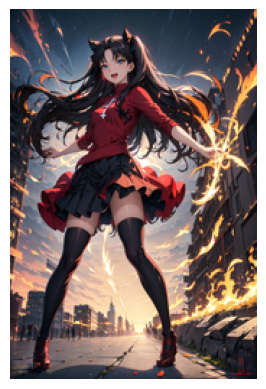

In [7]:
plt.axis('off')
plt.imshow(load_img(ai_paths[0]))

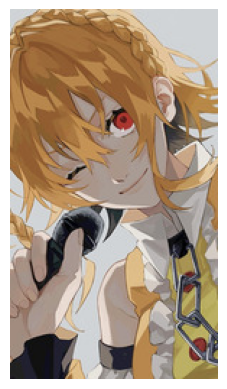

In [8]:
plt.axis('off')
plt.imshow(load_img(non_paths[0]))

## InceptionV3

### Data Preprocessing

In [9]:
img_size = (256,256) # untuk InceptionV3
batch_size = 32
trainval_dir = project_dir + "pixiv\\trainval\\"
test_dir = project_dir + "pixiv\\test\\"

In [10]:
train_val_gen = ImageDataGenerator(
    rescale=1./255, 
    zoom_range=0.2, 
    shear_range=0.2,
    horizontal_flip=True, 
    validation_split=0.0625
)

Dalam kasus ini, dilakukan augmentasi data dengan ImageDataGenerator (rescale, zoom, flip, split)

In [11]:
train_ds = train_val_gen.flow_from_directory(
    trainval_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

val_ds = train_val_gen.flow_from_directory(
    trainval_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
)

Found 1500 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


Karena menggunakan class_mode='binary', maka labelnya antara 0 atau 1. Lebih lanjut, label disusun sesuai alfabet, sehingga AI dilabeli 0 (negative), sementara non-AI dilabeli 1 (positive).

In [12]:
test_ds = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 400 images belonging to 2 classes.


Kita telah berhasil membagi 2000 gambar menjadi 1500 untuk train, 100 untuk validation, dan 400 untuk test

In [13]:
img, label = train_ds.next()

In [14]:
print (img.shape)

(32, 256, 256, 3)


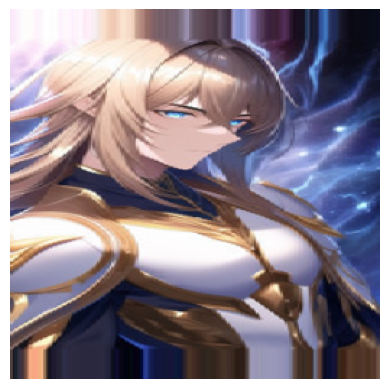

In [15]:
plt.axis('off')
plt.imshow(img[0])

Kita telah berhasil membuat training set dan testing set dan memanggil salah satu contoh data yang sudah di-augment

### Modeling

1. Melakukan tuning

In [16]:
img_shape = (256,256,3)

base_model1 = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=img_shape
)

In [17]:
base_model1.trainable=False

Function untuk membuat model dengan KerasTuner

In [18]:
batchs = []

def tune_model(params):  
    batchs = params.Choice("batch_size", [16,32])
    dr = params.Choice("dropout_rate", [0.1,0.2])
    lr = params.Choice("lr", [1e-3,1e-2])
    
    model = keras.models.Sequential()

    model.add(base_model1)

    model.add(layers.GlobalAveragePooling2D())
    
    model.add(layers.Dropout(dr))

    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=['accuracy',
             keras.metrics.Precision(),
             keras.metrics.Recall()
        ]
    )
    return model

In [19]:
tf.keras.utils.set_random_seed(42)

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy', 
        patience=3)
]

tuner = keras_tuner.BayesianOptimization(
    tune_model,
    objective="val_accuracy",
    max_trials=5,
    overwrite=True
)

tuner.search(train_ds, epochs=5, 
             batch_size=batchs, 
             callbacks=callbacks, 
             validation_data=val_ds
)

Trial 5 Complete [00h 09m 25s]
val_accuracy: 0.8500000238418579

Best val_accuracy So Far: 0.8799999952316284
Total elapsed time: 00h 47m 13s


Ditambahkan set_random_seed untuk mencegah hasil yang acak/ berganti-ganti jika di-train ulang.

In [20]:
tuner.results_summary(num_trials=5) # rangkuman dari terbaik ke terburuk

Results summary
Results in .\untitled_project
Showing 5 best trials
Objective(name="val_accuracy", direction="max")

Trial 0 summary
Hyperparameters:
batch_size: 32
dropout_rate: 0.2
lr: 0.001
Score: 0.8799999952316284

Trial 3 summary
Hyperparameters:
batch_size: 32
dropout_rate: 0.1
lr: 0.001
Score: 0.8500000238418579

Trial 4 summary
Hyperparameters:
batch_size: 16
dropout_rate: 0.1
lr: 0.001
Score: 0.8500000238418579

Trial 1 summary
Hyperparameters:
batch_size: 32
dropout_rate: 0.1
lr: 0.01
Score: 0.8399999737739563

Trial 2 summary
Hyperparameters:
batch_size: 16
dropout_rate: 0.2
lr: 0.001
Score: 0.8199999928474426


Dapat dilihat bahwa skor terbaik diperoleh dari parameter:
- Batch size = 32
- Pakai dropout 0.2
- learning-rate = 0.001 atau 1e-3

In [21]:
best_params = tuner.get_best_hyperparameters()[0]

best_params

In [22]:
batch = best_params['batch_size']
dropout_rate = best_params['dropout_rate']
learning_rate = best_params['lr']

batch_size

32

Kita berhasil melakukan tuning, selanjutnya kita uji di model InceptionV3.

2. Membuat model InceptionV3

In [23]:
def build_model(base_model):  
    model = keras.models.Sequential()

    model.add(base_model)

    model.add(layers.GlobalAveragePooling2D())

    model.add(layers.Dropout(dropout_rate))

    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=['accuracy',
                keras.metrics.Precision(),
                keras.metrics.Recall()
        ]
    )
    return model

In [24]:
tf.keras.utils.set_random_seed(42)

model1 = build_model(base_model1)

callbacks = [
    keras.callbacks.ModelCheckpoint('ai_detection_inceptionv3', save_best_only=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=3),
    keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=7)
]

history = model1.fit(train_ds, 
                    epochs=15, 
                    batch_size=batch,
                    callbacks=callbacks,
                    validation_data=val_ds)

Epoch 1/15
47/47 [==============================] - ETA: 0s - loss: 0.5896 - accuracy: 0.6887 - precision_1: 0.6974 - recall_1: 0.6667INFO:tensorflow:Assets written to: ai_detection_inceptionv3\assets


INFO:tensorflow:Assets written to: ai_detection_inceptionv3\assets


47/47 [==============================] - 230s 5s/step - loss: 0.5896 - accuracy: 0.6887 - precision_1: 0.6974 - recall_1: 0.6667 - val_loss: 0.5450 - val_accuracy: 0.7300 - val_precision_1: 0.7255 - val_recall_1: 0.7400 - lr: 0.0010
Epoch 2/15
47/47 [==============================] - 107s 2s/step - loss: 0.4507 - accuracy: 0.8040 - precision_1: 0.7850 - recall_1: 0.8373 - val_loss: 0.5452 - val_accuracy: 0.7100 - val_precision_1: 0.6615 - val_recall_1: 0.8600 - lr: 0.0010
Epoch 3/15
47/47 [==============================] - ETA: 0s - loss: 0.3821 - accuracy: 0.8400 - precision_1: 0.8338 - recall_1: 0.8493INFO:tensorflow:Assets written to: ai_detection_inceptionv3\assets


INFO:tensorflow:Assets written to: ai_detection_inceptionv3\assets


47/47 [==============================] - 194s 4s/step - loss: 0.3821 - accuracy: 0.8400 - precision_1: 0.8338 - recall_1: 0.8493 - val_loss: 0.4838 - val_accuracy: 0.8000 - val_precision_1: 0.8571 - val_recall_1: 0.7200 - lr: 0.0010
Epoch 4/15
47/47 [==============================] - ETA: 0s - loss: 0.3583 - accuracy: 0.8520 - precision_1: 0.8446 - recall_1: 0.8627INFO:tensorflow:Assets written to: ai_detection_inceptionv3\assets


INFO:tensorflow:Assets written to: ai_detection_inceptionv3\assets


47/47 [==============================] - 193s 4s/step - loss: 0.3583 - accuracy: 0.8520 - precision_1: 0.8446 - recall_1: 0.8627 - val_loss: 0.4364 - val_accuracy: 0.8400 - val_precision_1: 0.8696 - val_recall_1: 0.8000 - lr: 0.0010
Epoch 5/15
47/47 [==============================] - 107s 2s/step - loss: 0.3404 - accuracy: 0.8500 - precision_1: 0.8477 - recall_1: 0.8533 - val_loss: 0.4408 - val_accuracy: 0.8300 - val_precision_1: 0.8367 - val_recall_1: 0.8200 - lr: 0.0010
Epoch 6/15
47/47 [==============================] - ETA: 0s - loss: 0.3147 - accuracy: 0.8767 - precision_1: 0.8792 - recall_1: 0.8733INFO:tensorflow:Assets written to: ai_detection_inceptionv3\assets


INFO:tensorflow:Assets written to: ai_detection_inceptionv3\assets


47/47 [==============================] - 218s 5s/step - loss: 0.3147 - accuracy: 0.8767 - precision_1: 0.8792 - recall_1: 0.8733 - val_loss: 0.4075 - val_accuracy: 0.8600 - val_precision_1: 0.8333 - val_recall_1: 0.9000 - lr: 0.0010
Epoch 7/15
47/47 [==============================] - 99s 2s/step - loss: 0.2907 - accuracy: 0.8813 - precision_1: 0.8763 - recall_1: 0.8880 - val_loss: 0.4354 - val_accuracy: 0.8200 - val_precision_1: 0.7857 - val_recall_1: 0.8800 - lr: 0.0010
Epoch 8/15
47/47 [==============================] - 100s 2s/step - loss: 0.2712 - accuracy: 0.8987 - precision_1: 0.8987 - recall_1: 0.8987 - val_loss: 0.4491 - val_accuracy: 0.8000 - val_precision_1: 0.7586 - val_recall_1: 0.8800 - lr: 0.0010
Epoch 9/15
47/47 [==============================] - 105s 2s/step - loss: 0.2680 - accuracy: 0.8927 - precision_1: 0.8911 - recall_1: 0.8947 - val_loss: 0.4367 - val_accuracy: 0.8100 - val_precision_1: 0.8605 - val_recall_1: 0.7400 - lr: 0.0010
Epoch 10/15
47/47 [=================

INFO:tensorflow:Assets written to: ai_detection_inceptionv3\assets


47/47 [==============================] - 215s 5s/step - loss: 0.2679 - accuracy: 0.9013 - precision_1: 0.9146 - recall_1: 0.8853 - val_loss: 0.3883 - val_accuracy: 0.8600 - val_precision_1: 0.8103 - val_recall_1: 0.9400 - lr: 1.0000e-04
Epoch 11/15
47/47 [==============================] - ETA: 0s - loss: 0.2604 - accuracy: 0.9073 - precision_1: 0.9134 - recall_1: 0.9000INFO:tensorflow:Assets written to: ai_detection_inceptionv3\assets


INFO:tensorflow:Assets written to: ai_detection_inceptionv3\assets


47/47 [==============================] - 187s 4s/step - loss: 0.2604 - accuracy: 0.9073 - precision_1: 0.9134 - recall_1: 0.9000 - val_loss: 0.3769 - val_accuracy: 0.8600 - val_precision_1: 0.8103 - val_recall_1: 0.9400 - lr: 1.0000e-04
Epoch 12/15
47/47 [==============================] - 148s 3s/step - loss: 0.2570 - accuracy: 0.8973 - precision_1: 0.8931 - recall_1: 0.9027 - val_loss: 0.4087 - val_accuracy: 0.8500 - val_precision_1: 0.8182 - val_recall_1: 0.9000 - lr: 1.0000e-04
Epoch 13/15
47/47 [==============================] - 103s 2s/step - loss: 0.2575 - accuracy: 0.8987 - precision_1: 0.9041 - recall_1: 0.8920 - val_loss: 0.4134 - val_accuracy: 0.8300 - val_precision_1: 0.7895 - val_recall_1: 0.9000 - lr: 1.0000e-05


### Visualisasi Epoch

In [25]:
epochs = range(1, len(history.history['accuracy']) + 1)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

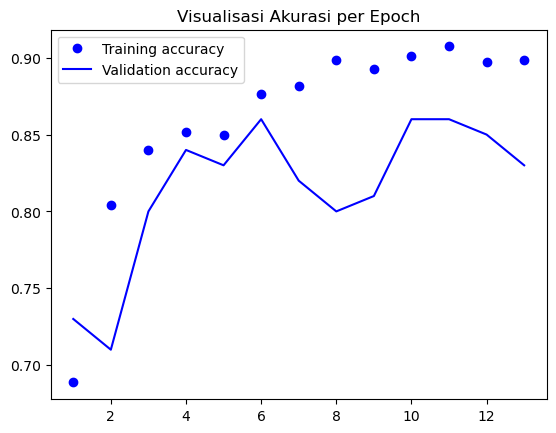

In [26]:
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')

plt.title('Visualisasi Akurasi per Epoch')

plt.legend()

### Evaluation

In [27]:
best_model1 = keras.models.load_model('ai_detection_inceptionv3')

best_model1.evaluate(test_ds)

13/13 [==============================] - 29s 2s/step - loss: 0.3294 - accuracy: 0.8550 - precision_1: 0.8777 - recall_1: 0.8250


[0.32940083742141724,
 0.8550000190734863,
 0.8776595592498779,
 0.824999988079071]

Kemudian, berikut merupakan evaluasi dengan Confusion Matrix.

In [28]:
labels_prob = best_model1.predict(test_ds)

13/13 [==============================] - 25s 2s/step


In [29]:
print (labels_prob.shape)

print (np.round(labels_prob[-10:]))

(400, 1)
[[1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


In [30]:
print (test_ds.labels.shape)

print (test_ds.labels[-10:])

(400,)
[1 1 1 1 1 1 1 1 1 1]


<Axes: >

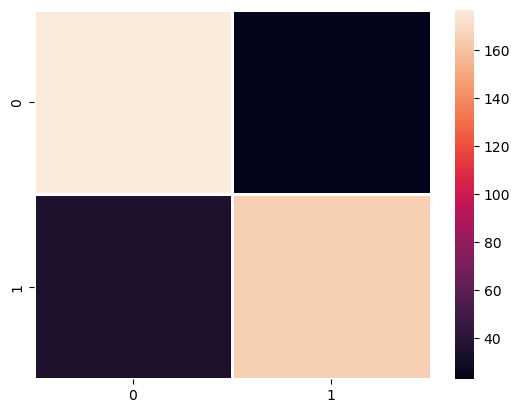

In [31]:
cm = confusion_matrix(test_ds.labels, np.round(labels_prob))

sns.heatmap(cm, linewidths=1) # tidak pakai annot karena tidak muncul

Dapat dilihat bahwa hasilnya cukup terang untuk TP dan TN, sementara cukup gelap pada FP dan FN, menandakan akurasi yang cukup baik.

In [32]:
print (classification_report(test_ds.labels, np.round(labels_prob)))

              precision    recall  f1-score   support

           0       0.83      0.89      0.86       200
           1       0.88      0.82      0.85       200

    accuracy                           0.85       400
   macro avg       0.86      0.85      0.85       400
weighted avg       0.86      0.85      0.85       400



Dapat dilihat bahwa hasil evaluasi InceptionV3 cukup memuaskan, dengan metrik evaluasi sebagai berikut:
- Precision: 86%
- Recall: 85%
- F1-score: 85%
- Accuracy: 85%

## MobileNet

Berbeda dari kasus InceptionV3, MobileNet hanya menerima input dengan ukuran terbesar 224x224, sehingga perlu di-resize 224x224 menggunakan ImageMagick

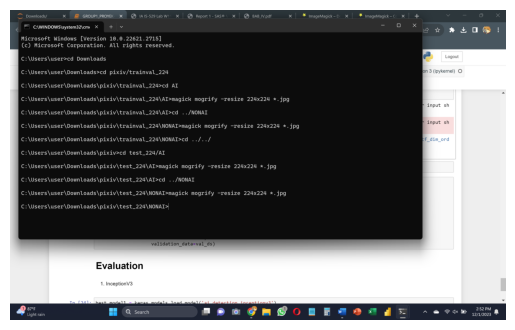

In [33]:
plt.axis('off')
plt.imshow(load_img(project_dir + "imagemagick-resize-224.png"))

### Data Preprocessing

In [34]:
img_size = (224,224)
batch_size = 32
trainval_dir = project_dir + "pixiv\\trainval_224\\"
test_dir = project_dir + "pixiv\\test_224\\"

In [35]:
train_val_gen = ImageDataGenerator(
    rescale=1./255, 
    zoom_range=0.2, 
    shear_range=0.2,
    horizontal_flip=True, 
    validation_split=0.0625
)

In [36]:
train_224_ds = train_val_gen.flow_from_directory(
    trainval_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

val_224_ds = train_val_gen.flow_from_directory(
    trainval_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

Found 1500 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [37]:
test_224_ds = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 400 images belonging to 2 classes.


Kita telah berhasil melakukan preprocessing.

In [38]:
img, label = train_224_ds.next()

In [39]:
print (img.shape)

(32, 224, 224, 3)


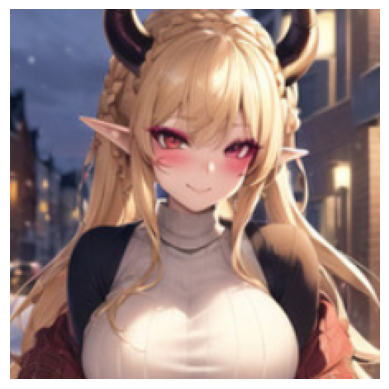

In [40]:
plt.axis('off')
plt.imshow(img[0])

Kita telah berhasil memanggil contoh data.

### Modeling

In [41]:
img_shape = (224,224,3)

base_model2 = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=img_shape
)

In [42]:
base_model2.trainable=False

In [43]:
tf.keras.utils.set_random_seed(42)

model2 = build_model(base_model2)

callbacks = [
    keras.callbacks.ModelCheckpoint('ai_detection_mobilenetv2', save_best_only=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=3),
    keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=7)
]

history = model2.fit(train_224_ds, 
                    epochs=15, 
                    batch_size=best_params['batch_size'],
                    callbacks=callbacks,
                    validation_data=val_224_ds)

Epoch 1/15
47/47 [==============================] - ETA: 0s - loss: 0.6450 - accuracy: 0.6353 - precision_2: 0.6274 - recall_2: 0.6667

INFO:tensorflow:Assets written to: ai_detection_mobilenetv2\assets


INFO:tensorflow:Assets written to: ai_detection_mobilenetv2\assets


47/47 [==============================] - 205s 4s/step - loss: 0.6450 - accuracy: 0.6353 - precision_2: 0.6274 - recall_2: 0.6667 - val_loss: 0.5912 - val_accuracy: 0.7000 - val_precision_2: 0.7273 - val_recall_2: 0.6400 - lr: 0.0010
Epoch 2/15
47/47 [==============================] - ETA: 0s - loss: 0.4768 - accuracy: 0.7713 - precision_2: 0.7633 - recall_2: 0.7867

INFO:tensorflow:Assets written to: ai_detection_mobilenetv2\assets


INFO:tensorflow:Assets written to: ai_detection_mobilenetv2\assets


47/47 [==============================] - 98s 2s/step - loss: 0.4768 - accuracy: 0.7713 - precision_2: 0.7633 - recall_2: 0.7867 - val_loss: 0.5312 - val_accuracy: 0.7400 - val_precision_2: 0.6935 - val_recall_2: 0.8600 - lr: 0.0010
Epoch 3/15
47/47 [==============================] - 43s 917ms/step - loss: 0.4094 - accuracy: 0.8087 - precision_2: 0.7964 - recall_2: 0.8293 - val_loss: 0.5348 - val_accuracy: 0.7500 - val_precision_2: 0.7778 - val_recall_2: 0.7000 - lr: 0.0010
Epoch 4/15
47/47 [==============================] - ETA: 0s - loss: 0.3740 - accuracy: 0.8320 - precision_2: 0.8294 - recall_2: 0.8360INFO:tensorflow:Assets written to: ai_detection_mobilenetv2\assets


INFO:tensorflow:Assets written to: ai_detection_mobilenetv2\assets


47/47 [==============================] - 118s 3s/step - loss: 0.3740 - accuracy: 0.8320 - precision_2: 0.8294 - recall_2: 0.8360 - val_loss: 0.5170 - val_accuracy: 0.7500 - val_precision_2: 0.7273 - val_recall_2: 0.8000 - lr: 0.0010
Epoch 5/15
47/47 [==============================] - 40s 848ms/step - loss: 0.3473 - accuracy: 0.8593 - precision_2: 0.8532 - recall_2: 0.8680 - val_loss: 0.5283 - val_accuracy: 0.7000 - val_precision_2: 0.7000 - val_recall_2: 0.7000 - lr: 0.0010
Epoch 6/15
47/47 [==============================] - ETA: 0s - loss: 0.3296 - accuracy: 0.8553 - precision_2: 0.8587 - recall_2: 0.8507INFO:tensorflow:Assets written to: ai_detection_mobilenetv2\assets


INFO:tensorflow:Assets written to: ai_detection_mobilenetv2\assets


47/47 [==============================] - 92s 2s/step - loss: 0.3296 - accuracy: 0.8553 - precision_2: 0.8587 - recall_2: 0.8507 - val_loss: 0.4690 - val_accuracy: 0.7800 - val_precision_2: 0.7593 - val_recall_2: 0.8200 - lr: 0.0010
Epoch 7/15
47/47 [==============================] - 44s 927ms/step - loss: 0.3083 - accuracy: 0.8700 - precision_2: 0.8705 - recall_2: 0.8693 - val_loss: 0.5623 - val_accuracy: 0.7700 - val_precision_2: 0.7288 - val_recall_2: 0.8600 - lr: 0.0010
Epoch 8/15
47/47 [==============================] - 44s 934ms/step - loss: 0.2900 - accuracy: 0.8820 - precision_2: 0.8805 - recall_2: 0.8840 - val_loss: 0.4834 - val_accuracy: 0.7700 - val_precision_2: 0.7213 - val_recall_2: 0.8800 - lr: 0.0010
Epoch 9/15
47/47 [==============================] - 43s 904ms/step - loss: 0.2777 - accuracy: 0.8900 - precision_2: 0.8895 - recall_2: 0.8907 - val_loss: 0.4707 - val_accuracy: 0.7700 - val_precision_2: 0.7872 - val_recall_2: 0.7400 - lr: 0.0010
Epoch 10/15
47/47 [===========

### Visualisasi Epoch

In [44]:
epochs = range(1,len(history.history['accuracy']) + 1)

acc2 = history.history['accuracy']
val_acc2 = history.history['val_accuracy']

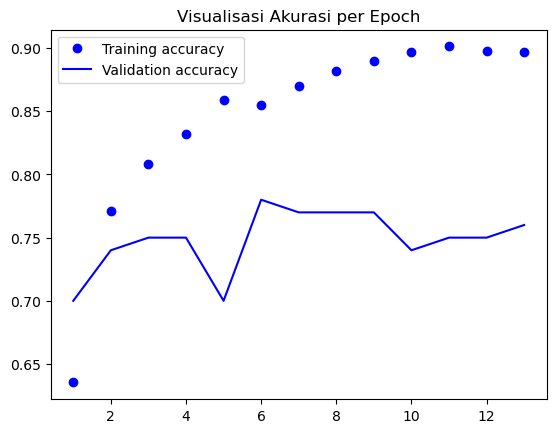

In [45]:
plt.figure()

plt.plot(epochs, acc2, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc2, 'b', label='Validation accuracy')

plt.title('Visualisasi Akurasi per Epoch')

plt.legend()

Sekilas dapat dilihat bahwa hasilnya sangat tidak memuaskan.

### Evaluation

In [46]:
best_model2 = keras.models.load_model('ai_detection_mobilenetv2')

best_model2.evaluate(test_224_ds)

13/13 [==============================] - 21s 2s/step - loss: 0.3735 - accuracy: 0.8225 - precision_2: 0.8525 - recall_2: 0.7800


[0.37351688742637634,
 0.8224999904632568,
 0.8524590134620667,
 0.7799999713897705]

Kemudian, berikut merupakan evaluasi dengan Confusion Matrix.

In [47]:
labels_prob2 = best_model2.predict(test_224_ds)

13/13 [==============================] - 8s 484ms/step


In [48]:
print (labels_prob2.shape)

print (np.round(labels_prob2[-10:]))

(400, 1)
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]]


In [49]:
print (test_224_ds.labels.shape)

print (test_224_ds.labels[-10:])

(400,)
[1 1 1 1 1 1 1 1 1 1]


<Axes: >

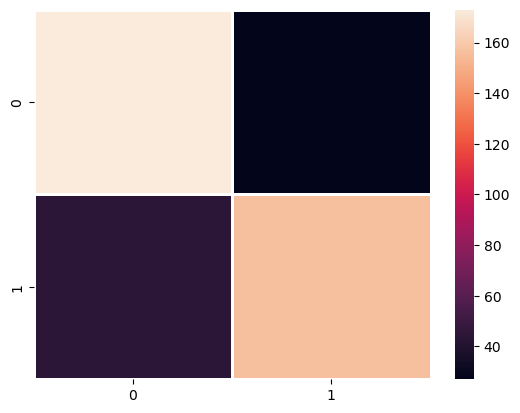

In [50]:
cm2 = confusion_matrix(test_224_ds.labels, np.round(labels_prob2))

sns.heatmap(cm2, linewidths=1)

Kurang lebih sama seperti kasus InceptionV3

In [51]:
print (classification_report(test_224_ds.labels, np.round(labels_prob2)))

              precision    recall  f1-score   support

           0       0.80      0.86      0.83       200
           1       0.85      0.78      0.81       200

    accuracy                           0.82       400
   macro avg       0.82      0.82      0.82       400
weighted avg       0.82      0.82      0.82       400



Dalam kasus ini, hasil evaluasi MobileNet kalah daripada InceptionV3, dengan perbedaan rata-rata 3 persen (82% < 85%)

## Deployment

In [29]:
%%writefile app.py

import streamlit as st
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow import keras

st.set_page_config(page_title='Deteksi Ilustrasi Anime Hasil Produksi AI generatif',
                   layout='wide')

st.header('Deteksi Ilustrasi Anime Hasil Produksi AI generatif')

col1, col2, col3 = st.columns(3)

inception_model = None # buat declare model

with col1:
    form = st.form("form_data")
    
    # function untuk upload gambar dalam try-catch
    def unggah_gambar():
        try:
            file = form.file_uploader("Unggah gambar di sini...", type=['png','jpeg','jpg'])
            
            img = Image.open(file)
        
            return img
        except:
            print ("Terjadi kesalahan saat mengunggah gambar.")
            
    
    data = unggah_gambar()

    submit = form.form_submit_button("Cek hasil")
    
with col2:
    if submit:
        st.image(data)
        
with col3:
    if submit:
        with st.spinner('Mohon ditunggu, model sedang bekerja...'):
            if inception_model is None:
                inception_model = keras.models.load_model('ai_detection_inceptionv3')
            
            # Resize image
            resized_data = data.resize((256, 256))
        
            # Rescale
            rescaled_data = img_to_array(resized_data) * 1./255
        
            # Numpy Array
            data_arr = np.array([rescaled_data])  
            
            # Hasil prediksi            
            y_prob = inception_model.predict(data_arr) 
            
        st.success('Selesai!')
        
        # seperti yang disebutkan di Data Preprocessing, AI dilabeli 0, sementara non-AI dilabeli 1 secara otomatis
        # dalam kasus ini, 100 - (probability non-AI, karena non-AI mendekati 1, sementara AI mendekati 0)
        
        hasil = 100 - (np.round(y_prob[0], 2) * 100)
        string_hasil = ("buatan AI" if hasil > 50 else "bukan buatan AI")
        
        # kalau lebih dari sama dengan 50 persen kemungkinannya tinggi buatan AI, 
        # sementara di bawah 50 persen berarti belom tentu
        
        st.write('Menurut model, gambar di samping ', string_hasil)
    
        st.write('Berikut merupakan persentasenya: ')
        st.write(hasil)

Overwriting app.py


In [30]:
!streamlit run app.py & npx localtunnel --port 8501

^C
